In [42]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
groq = ChatGroq(model="qwen-qwq-32b")
groq.invoke("What is testing")

AIMessage(content='\n<think>\nOkay, the user is asking, "What is testing?" Let me start by breaking down what they might need. They could be new to the concept, so I should explain it in simple terms. Testing is a broad term, so I should cover different contexts like software testing, scientific testing, etc.\n\nFirst, I need to define testing in general. Maybe start with a basic definition: purposefully evaluating something to check its quality, functionality, or effectiveness. That\'s a good starting point.\n\nThen, perhaps outline the key purposes. Like verifying if it meets requirements, identifying defects, ensuring reliability. That makes sense. But I should also mention that it\'s used in various fields, so examples would help. Software testing, medical tests, quality control in manufacturing.\n\nWait, the user might be thinking specifically about software testing since that\'s a common context. I should address that. Maybe include types of testing like unit testing, integration

In [43]:
from typing import Annotated,List
import operator
from typing_extensions import Literal,TypedDict

from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage
from typing_extensions import TypedDict

In [44]:
class Section(BaseModel):
    name:str=Field(description="The title of the section")
    description:str=Field(description="Brief overview of the main topics and concepts of the section")


class Sections(BaseModel):
    sections:List[Section]=Field(description="Sections of the report")

planner = groq.with_structured_output(Sections)

               

In [45]:
class State(TypedDict):
    title:str
    sections : List[Section]
    completed_sections : Annotated[list,operator.add]
    final_report : str

In [46]:
class WorkState(TypedDict):
    section:Section
    completed_section : Annotated[list,operator.add]

In [47]:
def orchestrator(state:State):
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan of the report"),
            HumanMessage(content=f"Here is the report topic: {state['title']}"),
        ]
    )

    return {"sections": report_sections.sections}

In [57]:
# Nodes
from langgraph.constants import Send
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkState):
    """Worker writes a section of the report"""

    # Generate section
    section = groq.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


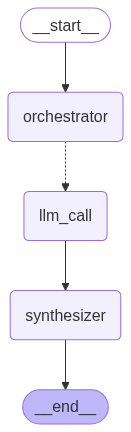

In [58]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [59]:
state = orchestrator_worker.invoke({"title": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

KeyError: 'topic'